**Gustavo Espinosa** &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp;   <img src= "https://i0.wp.com/immap.org/wp-content/uploads/2016/12/immap-logo-strap2.png?resize=300%2C45&ssl=1"> <br />
*July 2020*


# 1) UNHCR DEEP Data Preprocessing

<br />

**OVERVIEW:** 
- Import CSV of ACNUR DEEP data in a single langugae, no duplicates. 
- Convert into an encoded spreadsheet that is ready for Machine Learning.
- Explore encoded data
- Prep Cleaned Data  for machine learning.
    - strip punctuation
    - lower case

**To-do:**
- Finish cleaning:
    - stem words
    - remove stop words

*With help from: https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5*



In [5]:
# Import packages

import sys
!{sys.executable} -m pip install nltk

import sys
!{sys.executable} -m pip install langdetect

import sys
!{sys.executable} -m pip install wordcloud

#misc / unused
#import nltk
#from nltk.stem.lancaster import LancasterStemmer
import os
import json
import datetime
#stemmer = LancasterStemmer()

%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

from langdetect import detect

import numpy as np
import pandas as pd

#from os import path
#from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

  Using cached nltk-3.5.zip (1.4 MB)
     |████████████████████████████████| 673 kB 6.3 MB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434678 sha256=70d170a5d6f6d7a60df2b11c84fa4e4ccf07c96b9f3d2e663e4bdd8313d012de
  Stored in directory: /home/jovyan/.cache/pip/wheels/ff/d5/7b/f1fb4e1e1603b2f01c2424dd60fbcc50c12ef918bafc44b155
Successfully built nltk
  Using cached langdetect-1.0.8.tar.gz (981 kB)
  Created wheel for langdetect: filename=langdetect-1.0.8-py3-none-any.whl size=993191 sha256=7101bd395b7386dd9aee48b02ddbf0c3aec6cc7b7925513f2fb47b4d0cf98b2e
  Stored in directory: /home/jovyan/.cache/pip/wheels/1e/80/23/0a24928ec3a3906ff5027f38d2fea824e7e97f2ba7c83d91e3
Successfully built langdetect
     |████████████████████████████████| 216 kB 5.7 MB/s eta 0:00:01
  Created wheel for wordcloud: filename=wordcloud-1.7.0-cp38-cp38-linux_x86_64.whl size=487294 sha256=a66bf70d2c3cd8190551638616115f96dd6c5a6efb51b164dad097f5e7c320c0
  Stored in directory: /h

## PrepData Function

In [6]:
#Language must be a string object, 'en' or 'es'
#Output must be a string object, the name of the column

def PrepData(Language, Output):
    
    """ 
    |Summary Line  
    | 
    |Description of Function:
    |-----------
    |Removes duplicates, subsets a single language, 
    | encodes Output categories, and leaves only unique paragraphs
    |
    |
    |
    |Parameters: 
    |-----------
    |Language (str): the language you want to analyze, e.g. ('en' is English, 'es' is Spanish...)
    |Output (int): output categories, e.g. (Categories=['Casualties', 'Context', 'Displacement',...)
    |
    |
    |Returns: 
    |-----------
    |data_final_unique (DataFrame): pd DataFrame that has duplicates removed, single language, Output categories encoded, and unique paragraphs
    |output_names (List): list of the categories that were encoded from the original variable
    """
    
    ##############################
    # Subset the data based on the selected language
    
    if Language == 'en':
        chosen_data = english_data
    elif Language == 'es':
        chosen_data = spanish_data
    else:
        print("Error: inputted language must be 'en' or 'es'")
    
    ##############################
    # Define the polychotomous output and replace it with encoded variables for each option

    original_output = (Output)
    
    enc = OneHotEncoder(sparse=False)
    X = enc.fit_transform(chosen_data[original_output].values.reshape(-1,1))
    encoded_output = pd.DataFrame(X,columns=enc.categories_[0])
    encoded_data = pd.concat([chosen_data,encoded_output],axis=1).drop(columns=original_output)
    encoded_data
    
    ##############################
    # Explore how many unique paragraphs there are 

    #save the unique paragraphs and their indices in arrays
    unique_paragraphs = []
    unique_paragraphs_idx = []

    #iterate through the encoded data, add unique paragraphs to the array, add index of first instance of a unique paragraph to the array
    for i in range(0,len(encoded_data)):
        if (encoded_data['Modified Excerpt'][i]) not in unique_paragraphs:
            unique_paragraphs = unique_paragraphs + [encoded_data['Modified Excerpt'][i]]
            unique_paragraphs_idx.append(i)

    #identify the indices of each time a paragraph is the last of its kind before a new unique paragraph
    b4_unique_paragraph_idx = []

    for i in unique_paragraphs_idx:
        b4_unique_paragraph_idx.append(i-1)
    
    ##############################
    # Identify and split the data into input and output

    input_names = (['Lead Title', 'Modified Excerpt'])

    output_names = []

    for i in range(0,len(encoded_output.columns)):
        output_names.append(encoded_output.columns[i])

    data_input = encoded_data.drop(columns=output_names)
    data_output = encoded_data.drop(columns=input_names)
    
    ##############################
    # Generate a DataFrame for the new output with all 0s

    output_names

    index = list(range(0,len(encoded_data)))

    zeros = [0]*len(encoded_data)

    d = {}

    for i in range(0,len(output_names)):
        d[output_names[i]] = zeros

    empty_output = pd.DataFrame(data=d)
    
    ##############################
    # For each unique paragraph, replace the unique_paragraph_idx row with 1s in the outputs if appropriate

    def EncodeUniqueParagraphs(Output_Names):
        place = 0    

        for i in range(0,len(encoded_data)):

            #iterate through the output and if the i'th element is 1, replace the 0 in the i'th row of empty_output with a 1
            for x in range(0,len(Output_Names)):
                if data_output[Output_Names[x]][i] == 1:
                    empty_output[Output_Names[x]][unique_paragraphs_idx[place]]=1

                if data_output[Output_Names[x]][i] == 1:
                    empty_output[Output_Names[x]][unique_paragraphs_idx[place]]=1

                if data_output[Output_Names[x]][i] == 1:
                    empty_output[Output_Names[x]][unique_paragraphs_idx[place]]=1    

            if i in b4_unique_paragraph_idx: 
                place = place + 1
                #to mark a new paragraph move the place over 1 which will move us to the next unique_paragraph_idx

    EncodeUniqueParagraphs(output_names)
    
    ##############################
    # Concatenate the data_input and empty_output (though the empty_output is now filled with 1s and 0s)

    data_final = pd.concat([data_input,empty_output],axis=1)

    data_final_unique = data_final.iloc[unique_paragraphs_idx]
    
    return data_final_unique.reset_index(drop=True),output_names

In [7]:
# Load data from CSV 

raw_data = pd.read_csv("OriginalData.csv")

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (28,31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
# Do basic prep...

original_data = raw_data
original_data = original_data.drop_duplicates()
original_data = original_data.sort_values(by=['Modified Excerpt']).reset_index(drop=True) #should I assume my data is already sorted?

#check for missing data
original_data.isnull().sum().sort_values()

Date of Lead Publication                      0
Date Imported                                 0
Lead Title                                    0
Lead URL                                      0
Source                                        0
Modified Excerpt                              2
Author                                      148
AFFECTED GROUPS                             259
Reliability                                 285
Country (code)                              362
Country                                     362
Sectoral Information - Sector              3858
Sectoral Information - Subdimension        3858
Sectoral Information - Dimension           3858
Operational Environment - Dimension       13656
Operational Environment - Subdimension    13656
Departments (code)                        14175
Departments                               14175
Severity                                  15285
Sectoral Information - Subsectors         16828
Information Date (From)                 

In [9]:
# Choose your desired Output variable

desired_output = ('AFFECTED GROUPS')
desired_inputs = ['Lead Title','Author','Modified Excerpt']

#subset the data to exclude rows with NaN in the desired output and in our input, 'Modified Excerpt'
subset_data = original_data[original_data[desired_output].isnull()==False] # Optional, perhaps it is important to see which documents do not get classified at all
subset_data = subset_data[original_data['Modified Excerpt'].isnull()==False]

#subset the data to only include desired inputs and outputs for ease of processing
cols = (desired_inputs + [desired_output])
subset_data = subset_data[cols]

#check again for missing values
subset_data.isnull().sum()
subset_data

#remove duplicates, now that I have few enough fields that there would be lots of duplicates...
subset_data = subset_data.drop_duplicates().reset_index(drop=True)
subset_data

#remove urls
notUrlIDX = []

for i in range (0,len(subset_data)):
    #    notUrlIDX.append(i)
    condition = ("https" not in subset_data['Modified Excerpt'][i])
    notUrlIDX.append(condition)
    
subset_data = subset_data[notUrlIDX].reset_index(drop=True)

<ipython-input-9-0ef0c03fabc7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset_data = subset_data[original_data['Modified Excerpt'].isnull()==False]


In [10]:
#detect language
lang=[]

for i in range(0,len(subset_data)):
    lang.append(detect(subset_data['Modified Excerpt'][i]))
    
subset_data['Lang']=lang

    ##for some reason, I got an error when I tried to do it this shorter way
    
    #for i in range(0,len(original_data)):
        #original_data['Lang'][i]=detect(original_data['Modified Excerpt'][i])
        

In [11]:
#Split into Spanish, English, and 'Other' datasets

english_data = subset_data[subset_data['Lang']=='en'].reset_index(drop=True)
spanish_data = subset_data[subset_data['Lang']=='es'].reset_index(drop=True)
other_data = subset_data[(subset_data['Lang'] != 'en') & (subset_data['Lang'] != 'es')].reset_index(drop=True)

In [12]:
# Display summary information in a neat lil table

d={'Dataset':['Original','Subset','English','Spanish','Other'],
   'Total # of Entries':[len(original_data),len(subset_data),len(english_data),len(spanish_data),len(other_data)],
   '# of Unique Documents':[len(original_data['Lead Title'].unique()),len(subset_data['Lead Title'].unique()),len(english_data['Lead Title'].unique()),len(spanish_data['Lead Title'].unique()),len(other_data['Lead Title'].unique())],
   '# of Unique Paragraphs':[len(original_data['Modified Excerpt'].unique()),len(subset_data['Modified Excerpt'].unique()),len(english_data['Modified Excerpt'].unique()),len(spanish_data['Modified Excerpt'].unique()),len(other_data['Modified Excerpt'].unique())]}

overview = pd.DataFrame(data=d)
overview

,Dataset,Total # of Entries,# of Unique Documents,# of Unique Paragraphs
0,Original,37879,324,2630
1,Subset,3804,275,1796
2,English,1029,49,444
3,Spanish,2773,226,1351
4,Other,2,1,1


In [14]:
# Execute the PrepData function, effectively prepping the data for exploration and further cleaning

good_data,output_names=PrepData('en',desired_output)
good_data.to_csv("PreppedData.csv",index = False)

## Data Exploration and Further Preprocessing

In [15]:
# Load prepped data from CSV

raw_data = pd.read_csv("PreppedData.csv")

raw_data

,Lead Title,Author,Modified Excerpt,Lang,Affected,All,Asylum Seekers,Displaced,Host,IDP,In transit,Migrants,Non Displaced,Not affected,Others,Pendular,Permanent,Refugees,Returnees
0,Venezuelans in Colombia struggle to find healt...,Doctors Without borders,"""The lack of access to basic and specialized h...",en,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,"Venezuelan refugees are very vulnerable, emoti...",Handicap International - Humanity & Inclusion,"""The serious political and economic crisis in ...",en,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,Waning welcome: the growing challenges facing ...,Mixed Migration Centre,", family reunification combines with socio-eco...",en,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,Supporting solidarity: why the world must bols...,refugeesinternational,"1.4 million. Meanwhile, in NdS Department\nalo...",en,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,Waning welcome: the growing challenges facing ...,Mixed Migration Centre,"11 out of 13 participating States agreed, amon...",en,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,"WFP Colombia External Situation Report, 18 Jul...",World Food Programme,• In coordination with the Government of Colom...,en,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
440,Regional Refugee and Migrant Response Plan for...,R4V,• Protection: Refugees and migrants from Venez...,en,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
441,Regional Refugee and Migrant Response Plan for...,R4V,• Socio-economic inclusion: As the Venezuelan ...,en,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
442,Colombia and Ecuador: Population Movement - In...,international federation of red cross and cres...,• The Colombian Red Cross monitors from the na...,en,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


GENERAL WORD CLOUD


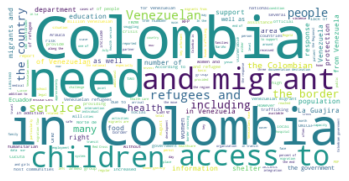

In [16]:
# Display Word Clouds for different labels

# For HELP:
    #?WordCloud
    #https://www.datacamp.com/community/tutorials/wordcloud-python
    #https://amueller.github.io/word_cloud/index.html

stopwords = set(STOPWORDS) #Must update with Spanish Stopwords
#stopwords.update(["Colombia","Colombian","Venezuelan"]) #Must add stopwords

#General
print("GENERAL WORD CLOUD")

total_text = ('')
for i in range(0,len(good_data)):
    total_text = total_text + good_data['Modified Excerpt'][i]

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(total_text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

AFFECTED WORD CLOUD


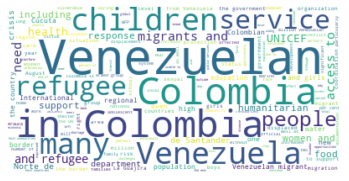

ALL WORD CLOUD


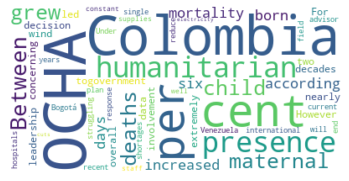

ASYLUM SEEKERS WORD CLOUD


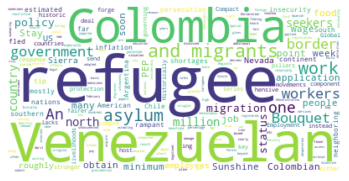

DISPLACED WORD CLOUD


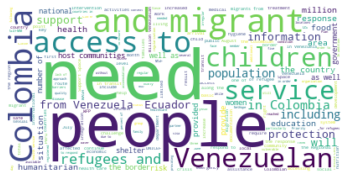

HOST WORD CLOUD


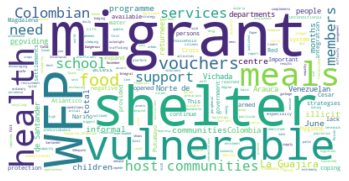

IDP WORD CLOUD


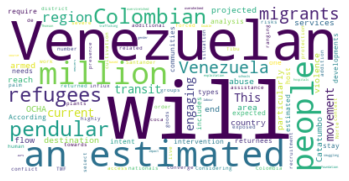

IN TRANSIT WORD CLOUD


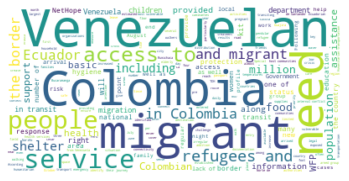

MIGRANTS WORD CLOUD


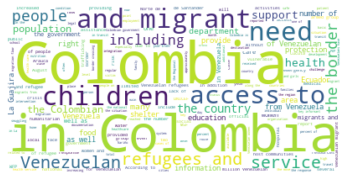

NON DISPLACED WORD CLOUD


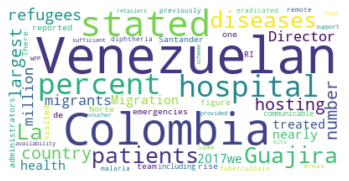

NOT AFFECTED WORD CLOUD


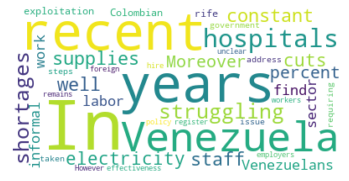

OTHERS WORD CLOUD


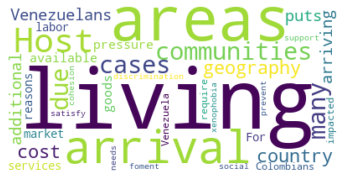

PENDULAR WORD CLOUD


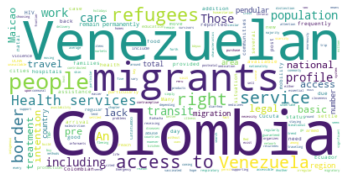

PERMANENT WORD CLOUD


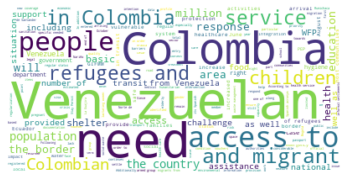

REFUGEES WORD CLOUD


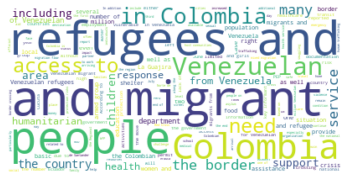

RETURNEES WORD CLOUD


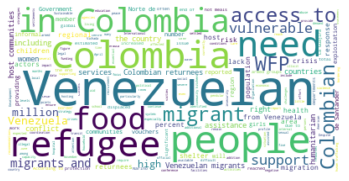

In [17]:
#Generate Word Clouds for each of the categories
for i in range(0,len(output_names)):
    print(output_names[i].upper() + " WORD CLOUD")
    total_text=('')
    condition = (good_data[output_names[i]]==1)
    for z in range(0,len(good_data[condition]['Modified Excerpt'].reset_index(drop=True))):
        total_text = total_text + " " + str(good_data[condition]['Modified Excerpt'].reset_index(drop=True)[z])
    total_text
    # Generate a word cloud image
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(total_text)

    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [18]:
# Check out some basic stats

category_counts = raw_data.sum(axis=0, numeric_only = True, skipna = True).to_frame()
category_counts['Category'] = category_counts.index
category_counts = category_counts.reset_index(drop=True)
#category_counts = category_counts.drop(columns='index')
category_counts.columns = ['count','category']
category_counts = category_counts[['category','count']]

category_counts

,category,count
0,Affected,93
1,All,3
2,Asylum Seekers,9
3,Displaced,109
4,Host,11
5,IDP,3
6,In transit,44
7,Migrants,407
8,Non Displaced,3
9,Not affected,2


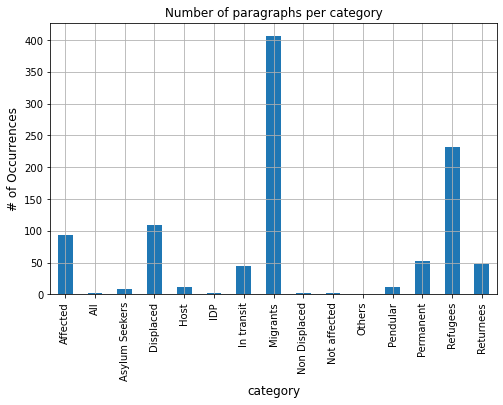

In [19]:
# Visualize the frequency of categories

category_counts.plot(x='category', y='count', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of paragraphs per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)
plt.show()

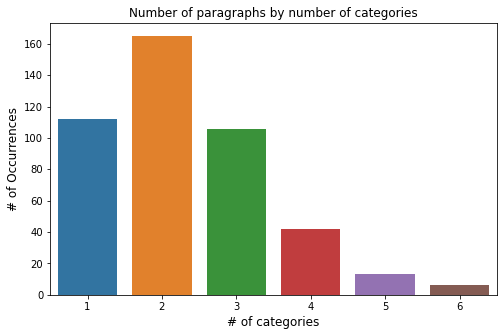

In [20]:
# Visualize how many comments have multi labels

rowsums = raw_data.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Number of paragraphs by number of categories")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)
plt.show()

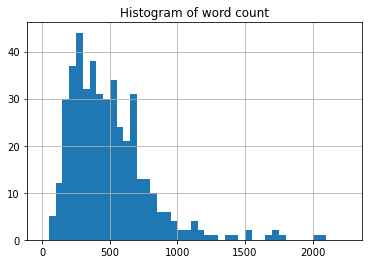

In [21]:
# Visualize number of words in the modified excerpts

min_ = raw_data['Modified Excerpt'].str.len().min()
max_ = raw_data['Modified Excerpt'].str.len().max()

lens = raw_data['Modified Excerpt'].str.len()
lens.hist(bins = np.arange(0,max_,50))
plt.title("Histogram of word count")
plt.show()

In [22]:
# Function to clean up the text - this could definitely be improved, including removal of stop words

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [23]:
# Clean the data using the function above
clean_data = raw_data

clean_data['Modified Excerpt'] = raw_data['Modified Excerpt'].map(lambda com : clean_text(com))
print("Example of cleaned text: ")
print("------------------------")
print(clean_data['Modified Excerpt'][0])

Example of cleaned text: 
------------------------
the lack of access to basic and specialized health services for venezuelans in colombia is a health crisis that needs more attention from the international community says ellen rymshaw msf head of mission in colombia the medical needs of this population have overwhelmed the colombian health system which at this time does not have the resources or personnel to attend to them due to these limitations many migrant patients have not been able to receive timely attention in hospital emergency rooms despite being entitled to this by law


In [25]:
#Save the cleaned data as a new csv
clean_data.to_csv("CleanData.csv",index = False)